## Importing Packages/Functions

In [3]:
import tarfile
import os
import uuid
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
import cv2
import shutil
import random
from joblib import dump, load

import torchvision
from importlib import reload
import collections
%load_ext tensorboard


## Extract/Examine Data

In [2]:
### extract challenge 2 data

tar = tarfile.open("Coding Challenge Stuff\challenge2.tar")
tar.extractall(filter='data')
tar.close()

In [3]:
### reading train/test set filenames

with open("challenge2\\train_set.txt") as file:
    train_file_md = file.readlines()
    
with open("challenge2\\test_set.txt") as file:
    test_file_md = file.readlines()



In [21]:
### examine the class balance

class_lists_dict = {'Chinchilla': [],
               'Hamster': [],
               'Rabbit': []}

train_file_md_class_names = [i[:-1].split('\\') for i in train_file_md]

for s0, s1 in train_file_md_class_names:
    class_lists_dict[s0].append(s1)

for k, v in class_lists_dict.items():
    print(f'{k} : {len(v)}')

Chinchilla : 37
Hamster : 28
Rabbit : 128


Data is heavily imbalanced, with far more images of rabbits than hamsters or  chinchillas.

## View sample images

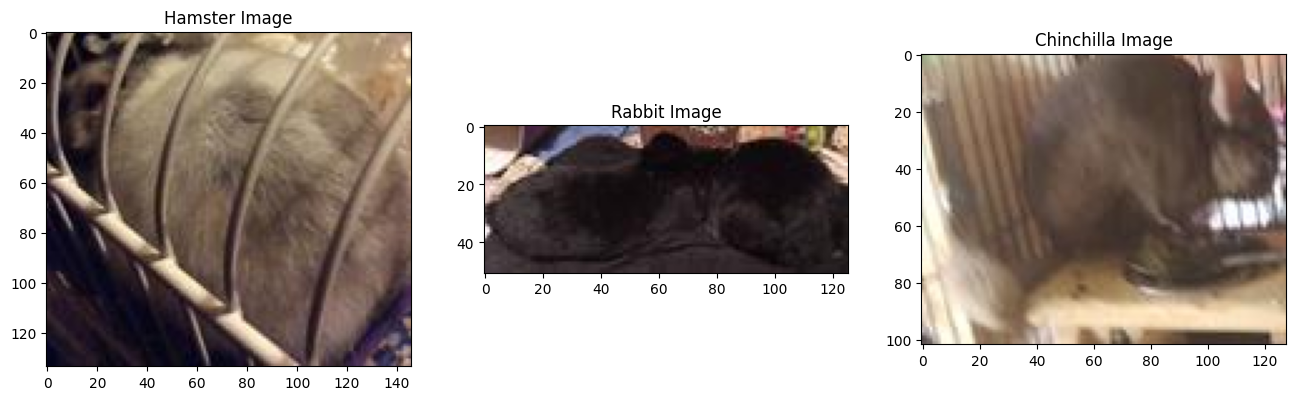

In [7]:
example_images = {'Hamster' : read_image('challenge2\data\Hamster\IMG_0065.jpg'),
                  'Rabbit' : read_image('challenge2\data\Rabbit\IMG_20211015_1943181.jpg'),
                  'Chinchilla' : read_image('challenge2\data\Chinchilla\IMG_20220321_0825007.jpg')}
n = 131
plt.figure(figsize=(16, 8))

for k, v in example_images.items():
    plt.subplot(n)
    plt.title(f"{k} Image")
    plt.imshow(v.permute(1, 2, 0))
    n+=1

All available training images were reviewed and considered. Images contain varying numbers of subjects (often overlapping subjects hiding salient details), and are of low resolution. It seem at least plausible that the test set will contain mixed subjects (representatives of multiple species). It is assumed that no additional class will be present (e.g. a dog), and for the purpose of the exercisse no effort will be made to account for such a situation.

It is decided prior to progressing to use a bounding box approach (masking is felt to be too laborious in this case, especially for examples where foreground objects obscure the animals, notably cage bars for hamsters).

An effort will be made to balance the classes by oversampling the Hamster and Chinchilla image data (note that the numbers of bounding boxes will not be balanced as a grat many Rabbit images contain >1 animal, whereas no Hamster image has >1 animal - in consequence this is a crude approximation of balancing).

Oversampling is performed by producing n copies of the Hamster & Chinchilla training sets, where n  = (no images of species X) / (no images of Rabbits).

Due to the variations in subject orientations/clarity of focus issues, it is decided to augment the data using random combinations of affine, reflction, rotation and blurring transfformations. Owing to hardware & time limitations only 2 augmented images will be produced from each image in the "balanced" dataset.



In [160]:
### Forming folders for "balanced" datasets

os.mkdir('balanced_training_data')
os.mkdir('balanced_training_data//Chinchilla')
os.mkdir('balanced_training_data//Rabbit')
os.mkdir('balanced_training_data//Hamster')

In [161]:
### Producing "balanced" copies

data_root = 'challenge2\\data\\'
co = 0
for k, v in class_lists_dict.items():
    ni = len(class_lists_dict['Rabbit'])//len(class_lists_dict[k])
    
    for n in range(ni):
        for i0 in v:
            src_filename = f'{data_root}\\{k}\\{i0}'
            dest_folder = f'balanced_training_data\\{k}'
            shutil.copy(src_filename, dest_folder)
            
            new_filename = f'Balanced_{n}_{i0}'
            os.rename(f'{dest_folder}\\{i0}', f'{dest_folder}\\{new_filename}')

In order to produce bounding boxes with class labels etc., images were uploaded and manually labelled/bounding boxes drawn to a [roboflow](https://roboflow.com/) project, with the bounding box information downloaded and stored at Coding_Challenge\\train\\_annotations.csv.

The following cells contain various functions used in this process.

In [59]:
## bounding box data from RoboFlow

taf = pd.read_csv('C:\\Users\\richard.nicklin\\Git_Repos\\Coding_Challenge\\train\\_annotations.csv')
taf

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_0093_jpg.rf.007bc49f1cc23e72412dc1ff125e20...,127,108,Hamsters,6,6,126,103
1,IMG_20230825_2158124_jpg.rf.0059ef538c10cfd93e...,127,81,Rabbit,1,14,125,77
2,IMG_0077_jpg.rf.13e52e99196a825a59c008d1f90277...,127,127,Hamsters,8,5,123,127
3,IMG_20211015_1921376_jpg.rf.0575958feee0153b71...,237,170,Rabbit,2,0,94,136
4,IMG_20211015_1921376_jpg.rf.0575958feee0153b71...,237,170,Rabbit,63,24,237,162
...,...,...,...,...,...,...,...,...
249,IMG_20211015_1950539_jpg.rf.fc27cebea213b9ec2b...,192,169,Rabbit,114,25,189,111
250,IMG_20211015_1950539_jpg.rf.fc27cebea213b9ec2b...,192,169,Rabbit,2,27,141,164
251,IMG_20230606_1721524_jpg.rf.fc8a6a4052f8e35c8d...,216,264,Rabbit,3,0,210,255
252,IMG_20231003_1545263_jpg.rf.eeeb40dbd7e7148c13...,127,108,Rabbit,0,24,127,108


C:\Users\richard.nicklin\AppData\Roaming\Python\Python310\site-packages\torchvision\utils.py:224: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


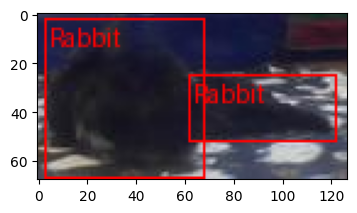

In [47]:
# Demonstrate the bounding boxes
idx = 100

##read in the image
img = read_image(f"challenge2\\data\\{train_file_md[idx][:-1]}")  

## get the species class:
species_class, lp = train_file_md[idx].split('\\') 

## get unique JPEG number
lp = lp.split('.')[0]

##find relevant annotations from RoboFlow output and construct target dictionary.
annotations = taf[taf['filename'].str.contains(lp)]
annotations = annotations.drop(annotations[annotations['xmin'] >= annotations['xmax']].index)
annotations = annotations.drop(annotations[annotations['ymin'] >= annotations['ymax']].index)

labels = [species_class,]*len(annotations)
boxes = annotations[['xmin', 'ymin', 'xmax', 'ymax']].values

boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))

output_image = draw_bounding_boxes(img, boxes, labels, colors="red", font_size = 12)

plt.figure(figsize=(4, 3))
plt.imshow(output_image.permute(1, 2, 0))

In [5]:
### Forming folders for "balanced" and augmented datasets
# os.mkdir('augmented_balanced_data')
# os.mkdir('augmented_balanced_data//Training_Data')
# os.mkdir('augmented_balanced_data//Val_Data')

transforms = [v2.RandomAffine(degrees=(30, 270), translate=(0.0, 0.25), scale=(0.75, 1.1)),
              v2.RandomPerspective(distortion_scale=0.25, p=1.0),
              v2.RandomHorizontalFlip(p=1.0),
              v2.GaussianBlur(kernel_size=(5, 9), sigma=(1, 3))]

## Helper function to copy image tensors and target dictionaries in a single call.  

def copy_image_and_target(img, target):
    img0 = img.clone().detach()
    target0 = {}
    for k, v in target.items():
        if isinstance(v, tv_tensors.BoundingBoxes):
            target0[k] = v.clone().detach()
        elif isinstance(v, torch.Tensor):
            target0[k] = v.clone().detach()
        else:    
            target0[k] = v
            
    return img0, target0

## Twin helper functions to save/load target dictionaries. In a future refactor this hould all be extracted to a utils class
## and a "class Target" created to house targets and their associated functions.

def custom_target_save(target, folder_name):
    os.mkdir(folder_name)
    
    for k, v in target.items():
        if isinstance(v, tv_tensors.BoundingBoxes):
            torch.save(v, f'{folder_name}/{k}.pt')
        elif isinstance(v, torch.Tensor):
            torch.save(v, f'{folder_name}/{k}.pt')
        else:    
            dump(v, f'{folder_name}/{k}')
            
    return True

def custom_target_load(folder_name):
    target ={}
    
    target['area'] = load(f'{folder_name}/area')
    target['iscrowd'] = torch.load(f'{folder_name}/iscrowd.pt').to(torch.uint8)
    target['labels'] = torch.load(f'{folder_name}/labels.pt').to(torch.uint8)
    target['boxes'] = torch.load(f'{folder_name}/boxes.pt').float()
    target['image_id'] = load(f'{folder_name}/image_id')
    
            
    return target

## Necessary to define a random_transform function for the purposes as existing 
## Torchvision Augmnetation pipelines do not work for instances of tv_tensor.BoundingBox

def random_transform(img, target, transforms, n = 0):
    try:
        img0, target0 = copy_image_and_target(img, target)
        tru = random.choice(transforms)
        img0, target0 = tru(img0, target0)
        ## test for a valid transformation of the boundary boxes:
        ar = (target0['boxes'][:, 3] - target0['boxes'][:, 1]) * (target0['boxes'][:, 2] - target0['boxes'][:, 0])
        if torch.any(ar<=1.0):
            raise ValueError
        return img0, target0
    except ValueError: ## defence against known issue in RandomAffine wrt BoundingBox transformations
        if n >= 3:
            img0, target0 = copy_image_and_target(img, target)
            return transforms[3](img0, target0)
        else:
            n+=1
            return random_transform(img, target, transforms, n = n)
        
    return

## Simplistic function to divide images and targets between training and validation sets in a 2:1 ratio.

def where_do_we_save(n=3):
    loc = 'Training_Data'
    if (random.randint(0,n) == 0):
        loc = 'Val_Data'
    return loc

## Augmenter class 

class CHR_Augmenter():
    def __init__(self, 
                 image_list_txt, ## initial train or test set .txt file
                 annotations_file, ## annotation from RoboFlow containing bounding box data 
                 balanced_data_folder, ## folder containing balanced data
                 labelling_dict, ## species: class number
                 transforms, ## transformation set to be selected from 
                 augmented_path = 'augmented_balanced_data' ## destination folder
                 ):

        self.labelling_dict = labelling_dict
        self.annotations_file = pd.read_csv(annotations_file)
        self.balanced_data_folder = balanced_data_folder
        self.balanced_imgs_filenames = list(os.listdir(balanced_data_folder))
        self.transforms = transforms
        self.augmented_path = augmented_path
        
        with open(f"challenge2\\{image_list_txt}") as file:
            self.file_md = file.readlines()
 
        self.imgs = [f'challenge2\\data\\{i[:-1]}'for i in self.file_md]
    
    
    ## TODO: Followng function is of excesive length/complexity: should be decomposed.
    
    def augment_and_save(self, idx):
        target= {}
        target["image_id"] = idx
        
        ## get the species class:
        species_class, lp = self.file_md[idx].split('\\') 
        
        ## get unique JPEG number
        lp = lp.split('.')[0]
        
        if '~' in lp:
            lp = lp.split('~')[0]
        
        ## get the balanced images filenames
        balanced_data_species_folder = f'{self.balanced_data_folder}\\{species_class}'
        self.balanced_imgs_filenames = list(os.listdir(balanced_data_species_folder))
        balanced_img_names = [i for i in self.balanced_imgs_filenames if lp in i]
        
        ##read in the images, reduce to torch float32 for memory conservation
        imgs = [read_image(f'{balanced_data_species_folder}\\{i}').to(torch.float32).cuda()*(1/256) for i in balanced_img_names]
        
        ##find relevant annotations from RoboFlow output and construct target dictionary.
        annotations = self.annotations_file[self.annotations_file['filename'].str.contains(lp)]
        
        ## check for invalid boxes
        annotations = annotations[((annotations['xmax'] - annotations['xmin']) > 10) &
                                  ((annotations['ymax'] - annotations['ymin']) > 10)]
        
        annotations = annotations.drop(annotations[annotations['xmin'] >= annotations['xmax']].index)
        annotations = annotations.drop(annotations[annotations['ymin'] >= annotations['ymax']].index)
        
        for k, v in labelling_dict.items():
            if k in self.imgs[idx]:
                labels = [v,]*len(annotations)
                target["labels"] = torch.tensor(labels, dtype=torch.int16).cuda()
        
        boxes = annotations[['xmin', 'ymin', 'xmax', 'ymax']].values
        target['boxes'] = tv_tensors.BoundingBoxes(boxes, 
                                                   format="XYXY", 
                                                   canvas_size=F.get_size(imgs[0]), 
                                                   device = torch.device('cuda')).to(torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["area"] = area
        # no instances are crowd
        iscrowd = torch.zeros((len(annotations),), dtype=torch.int16).cuda()
        target["iscrowd"] = iscrowd

        for img in imgs:
            ##unique id
            uu = str(uuid.uuid4())
            ##determine train/val split 
            loc = where_do_we_save()
            ## reduce to torch float16 for memory conservation
            img = img.to(torch.float16)
            torch.save(img, f'{self.augmented_path}//{loc}//Images//{uu}')
            custom_target_save(target, f'{self.augmented_path}//{loc}//Targets//{uu}')
            
            for _ in range(3):
                ## produce 3 augments and save
                img_l, target_l = random_transform(img, target, transforms)
                uu = str(uuid.uuid4())
                loc = where_do_we_save()
                ## reduce to torch float16 for memory conservation
                img_l = img_l.to(torch.float16)
                torch.save(img_l, f'{self.augmented_path}//{loc}//Images//{uu}')
                custom_target_save(target_l, f'{self.augmented_path}//{loc}//Targets//{uu}')
        
        return True

    def __len__(self):
        return len(self.imgs)
    
    
## expedient clean up function in the event of errors:
def clean_up_after_aug():
    categories = ['Images', 
                  'Targets']
    species = [
               'Hamster',
               'Rabbit',
               'Chinchilla',
               'Val_Data',
               'Training_Data']
    
    for i1 in categories:
        for i0 in species:
            loc = f'augmented_balanced_data//{i0}//{i1}'
            lol = list(os.listdir(loc))
            
            for i2 in lol:
                try:
                    if i1 == "Targets":
                        shutil.rmtree(f'{loc}//{i2}')
                    else:
                        os.remove(f'{loc}//{i2}')
                except PermissionError:
                    print(f'Permission error {loc}')
                    continue
                except FileNotFoundError:
                    print(f'FileNotFound error {loc}')
                    continue
                    
    return

In [8]:
clean_up_after_aug()

In [9]:
## labelling dictionary for species: class number. Note that the "0th" class is for "crowd" in COCO based models.
labelling_dict = {'Chinchilla': 1,
                  'Hamster': 2,
                  'Rabbit': 3,
                 }

## Perform augmentation

chra = CHR_Augmenter('train_set.txt',
                     annotations_file = 'C:\\Users\\richard.nicklin\\Git_Repos\\Coding_Challenge\\train\\_annotations.csv',
                     balanced_data_folder = 'balanced_training_data',
                     labelling_dict = labelling_dict,
                     transforms = transforms)
                 

for _ in range(chra.__len__()):
    chra.augment_and_save(_)

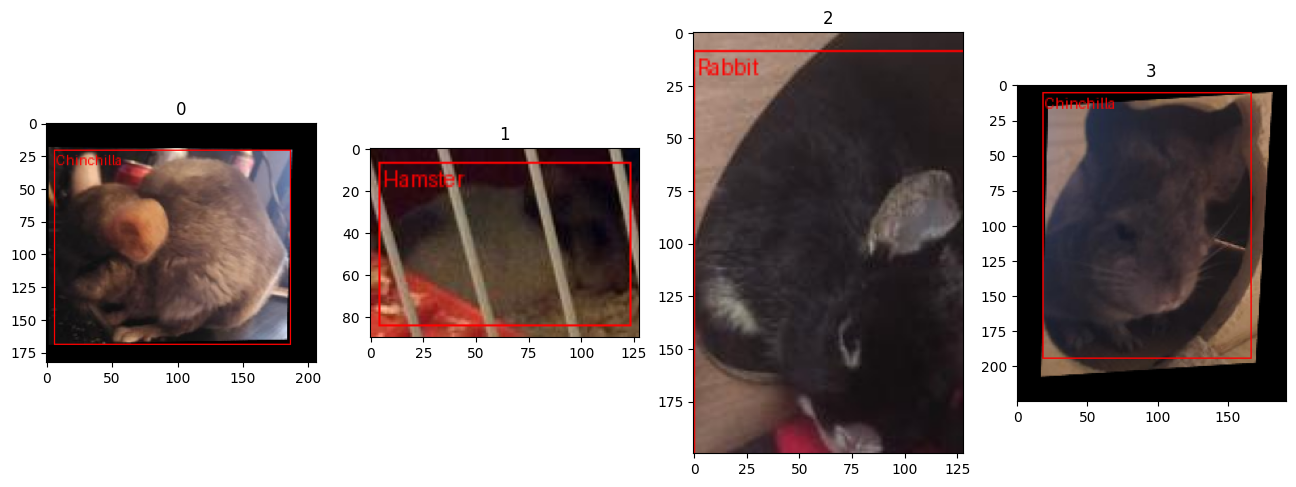

In [11]:
### Visualise and check augmented training data (only first 4 images shown to save memory)

train_uus = list(os.listdir('augmented_balanced_data\\Training_Data\\Images'))
# hu = (len(train_uus)//4)+1
fig, axs = plt.subplots(1, 4, figsize=(16, 600))
num_uu = {}
for n, uu in enumerate(train_uus):
    num_uu[n] = uu
    ##read in the image
    img = (torch.load(f"augmented_balanced_data\\Training_Data\\Images\\{uu}")*256).cpu().to(torch.uint8)

    ##find relevant annotations from RoboFlow output and construct target dictionary.
    target = custom_target_load(f"augmented_balanced_data\\Training_Data\\Targets\\{uu}")
    
    boxes = target['boxes']
    labels_nos = target['labels'].cpu().numpy()
    labels = []
    for i in range(labels_nos.shape[0]):
        for k, v in labelling_dict.items():
            if labels_nos[i] == v:
                labels.append(k)

    output_image = draw_bounding_boxes(img, boxes, labels, colors="red")
    
#     n1 = n//4
#     n2 = n%4
    
#     axs[n1, n2].imshow(output_image.permute(1, 2, 0))   
#     axs[n1, n2].set_title(f"{n}")
    axs[n].imshow(output_image.permute(1, 2, 0))   
    axs[n].set_title(f"{n}")
    
    if n>=3:
        break

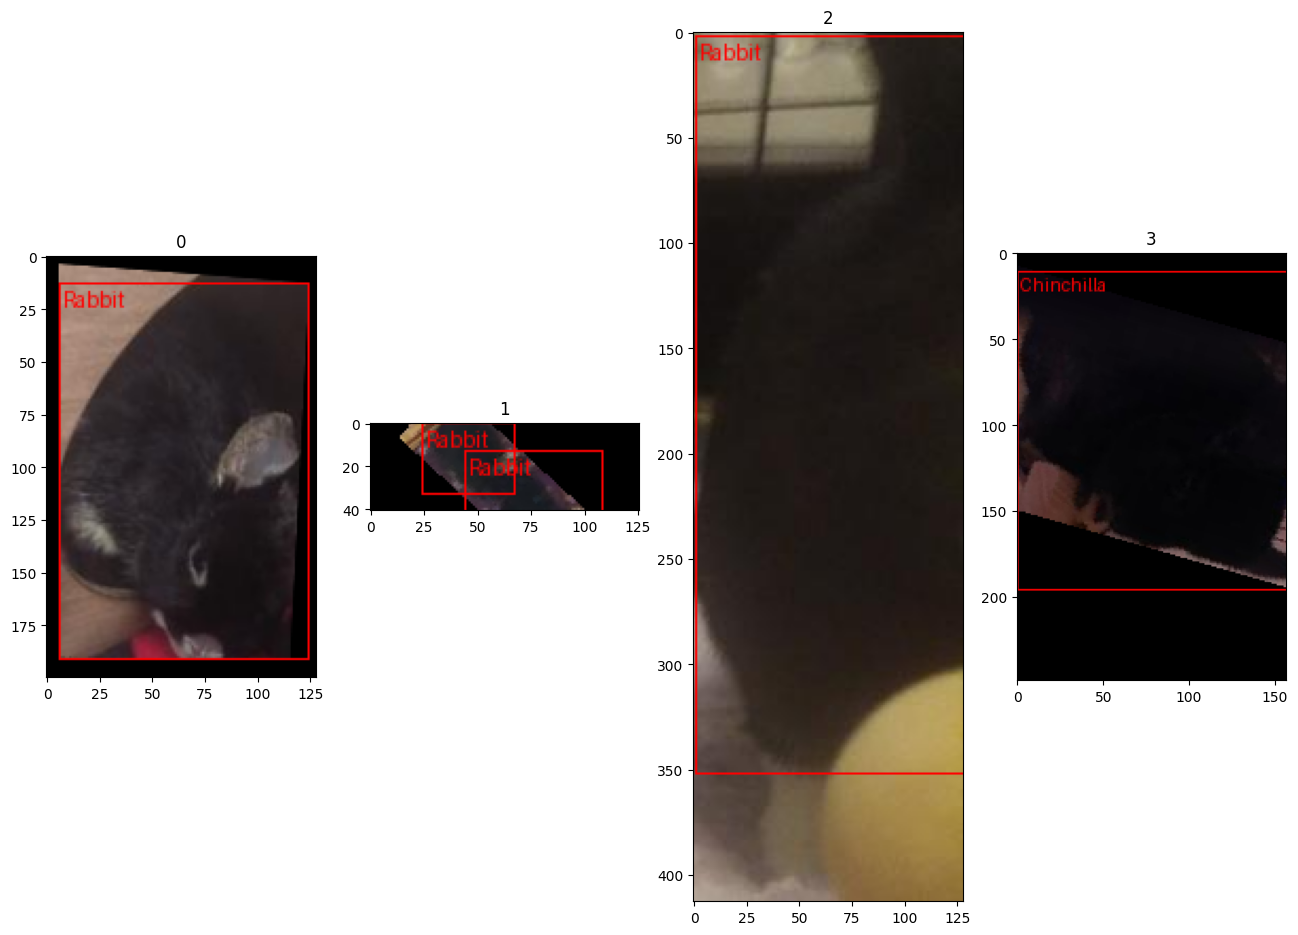

In [13]:
### Visualise and check augmented validaion data

val_uus = list(os.listdir('augmented_balanced_data\\Val_Data\\Images'))
hu = (len(val_uus)//4)+1
fig, axs = plt.subplots(1, 4, figsize=(16, 20))
num_uu = {}
for n, uu in enumerate(val_uus):
    num_uu[n] = uu
    ##read in the image
    img = (torch.load(f"augmented_balanced_data\\Val_Data\\Images\\{uu}")*256).cpu().to(torch.uint8)

    ##find relevant annotations from RoboFlow output and construct target dictionary.
    target = custom_target_load(f"augmented_balanced_data\\Val_Data\\Targets\\{uu}")
    
    boxes = target['boxes']
    labels_nos = target['labels'].cpu().numpy()
    labels = []
    for i in range(labels_nos.shape[0]):
        for k, v in labelling_dict.items():
            if labels_nos[i] == v:
                labels.append(k)

    output_image = draw_bounding_boxes(img, boxes, labels, colors="red")
    
#     n1 = n//4
#     n2 = n%4
    
#     axs[n1, n2].imshow(output_image.permute(1, 2, 0))
    
#     axs[n1, n2].set_title(f"{n}")
    axs[n].imshow(output_image.permute(1, 2, 0))
    axs[n].set_title(f"{n}")
    if n >= 3:
        break